# Self Organizing Map

SOM are used to dimension reduction. This can be used for clustering for futher processing or for visualization of higly dimensional data in lower dimensions.

This tutorial will map 3d color space into 2d. This is 'hello world' for SOM.

The algorithm works in the following steps:

 1. Intialize output grid weights to the random numbers
 2. For each input vector (data point)
   1. Find node in the grid neartes to the input vector (BMU)
   2. Update weights of the BMU to reflect input vector
   3. Update all neightbors of BMU to match input vector. The closer nodes are modified more
   
The range of neighbors shrinks over time.

**Warning** This algorithm takes a lot of time.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Initialize output space to random variables

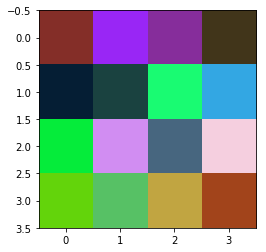

In [117]:
output_size = 4

output = np.random.uniform(size=(output_size*output_size, 3))

def plot_output(out):
    plt.imshow(out.reshape([output_size, output_size, 3]))
    plt.show()
    
plot_output(output)    

Prepare TensorFlow structures

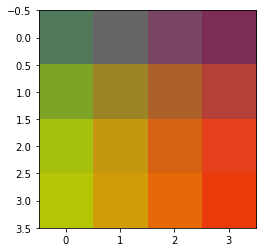

In [122]:
iter_count = 1
# Initialize
nodes = tf.Variable(output, dtype=tf.float32)
node_locs = get_locs()
x = tf.placeholder(tf.float32, [dim])
step = tf.placeholder(tf.float32)


def get_locs():
    locs = [[x,y] for y in range(output_size) for x in range(output_size)]
    return tf.to_float(locs)


# Update grid
def get_propagation(bmu_loc, x, i):
    num_nodes = output_size * output_size
    rate = 1.0 - tf.div(i, iter_count)
    alpha = rate * 0.5
    sigma = rate * tf.to_float(output_size / 2.0)
    expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0)
    sqr_dist_bmu = tf.reduce_sum(tf.square(tf.subtract(expanded_bmu_loc, node_locs)), 1)
    neigh_factor = tf.exp(-tf.div(sqr_dist_bmu, 2*tf.square(sigma)))
    rate = tf.multiply(alpha, neigh_factor)
    rate_factor = tf.stack( [tf.tile(tf.slice(rate, [i], [1]), [3]) for i in range(output_size*output_size)] )
    nodes_diff = tf.multiply(rate_factor, tf.subtract(tf.stack([x for i in range(output_size*output_size)]), nodes))
    update_nodes = tf.add(nodes, nodes_diff)
    return tf.assign(nodes, update_nodes)
    
    
# Find BMU
def get_bmu_loc(x):
    expanded_x = tf.expand_dims(x, 0)
    sqr_diff = tf.square(tf.subtract(expanded_x, nodes))
    dist = tf.reduce_sum(sqr_diff, 1)
    bmu_idx = tf.argmin(dist, 0)
    bmu_loc = tf.stack([tf.mod(bmu_idx, output_size), tf.div(bmu_idx, output_size)])
    return bmu_loc
    
    
colors = np.array(
    [ [0.0, 0.0, 1.0]
    , [0.0, 0.0, 0.95]
    , [0.0, 0.05, 1.0]
    , [0.0, 1.0, 0.0]
    , [0.0, 0.95, 0.0]
    , [0.0, 1.0, 0.05]
    , [1.0, 0.0, 0.0]
    , [1.0, 0.05, 0.0]
    , [1.0, 0.0, 0.05]
    , [1.0, 1.0, 0.0]
    ])    

x1 = tf.constant(output[1, :], dtype=tf.float32)
with tf.Session() as sess:   
    sess.run(tf.global_variables_initializer())
    propagate_nodes = get_propagation(get_bmu_loc(x), x, step)
    for i in range(iter_count):
        for c in colors:
            sess.run(propagate_nodes, feed_dict={x: c, step: i})
    node_vals = sess.run(nodes)
    plot_output(node_vals)